**Part 1**

For this homework I will be using the Top 10,000 companies data set. This dataset contains information on 10,000 different companies sourced from Ambition Box, a platform that provides insights into company reviews, ratings, salaries, interviews, and more.

Link to the data set can be found [here](https://www.kaggle.com/datasets/vedantkhapekar/top-10000-companies-dataset)

Begin by cleaning and getting insights on the data.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv("companies.csv")

# Data Preprocessing
df = df.replace('--', np.nan)  # Replace '--' with NaN
df = df.dropna()  # Remove missing values

# Function to convert string numbers with 'k' into numeric values
def convert_k_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'k' in value:
            return float(value.replace('k', '')) * 1000  # Convert 'k' to thousand
        try:
            return float(value)
        except ValueError:
            return None  # Return None if conversion fails
    return value

# Apply conversion to relevant columns
numeric_columns = ["Total_reviews", "Avg_salary", "Interviews_taken", "Total_jobs_available", "Total_benefits"]
for col in numeric_columns:
    df[col] = df[col].apply(convert_k_to_number).astype('Int64', errors='ignore')

# Fill missing values in categorical columns with "Not Available"
df["Highly_rated_for"] = df["Highly_rated_for"].fillna("Not Available")
df["Critically_rated_for"] = df["Critically_rated_for"].fillna("Not Available")

# Standardize column names (lowercase and replace spaces with underscores)
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Show cleaned data summary
df.info(), df.head()

# Select features and target
X = df[['ratings', 'total_reviews', 'avg_salary', 'interviews_taken', 'total_jobs_available']]
y = (df['ratings'] >= 4.0).astype(int).values  # Binary classification: 1 for high-rated, 0 for low-rated

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
Index: 1560 entries, 0 to 9958
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company_name          1560 non-null   object 
 1   description           1560 non-null   object 
 2   ratings               1560 non-null   float64
 3   highly_rated_for      1560 non-null   object 
 4   critically_rated_for  1560 non-null   object 
 5   total_reviews         1560 non-null   Int64  
 6   avg_salary            1560 non-null   float64
 7   interviews_taken      1560 non-null   Int64  
 8   total_jobs_available  1560 non-null   Int64  
 9   total_benefits        1560 non-null   Int64  
dtypes: Int64(4), float64(2), object(4)
memory usage: 140.2+ KB


Now we will implement the Neural Network

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, batch_size=32):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
        self.batch_size = batch_size

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def derivative(self, z):
        return z * (1 - z)

    def forward_propagation(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    def backward_propagation(self, X, y, output):
        m = X.shape[0]
        error = output - y.reshape(-1, 1)
        dZ2 = error * self.derivative(output)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0) / m

        dZ1 = np.dot(dZ2, self.W2.T) * self.derivative(self.A1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0) / m

        # Update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
          for i in range(0, X.shape[0], self.batch_size):
              X_batch = X[i:i + self.batch_size]
              y_batch = y[i:i + self.batch_size]
              output = self.forward_propagation(X_batch)
              self.backward_propagation(X_batch, y_batch, output)
          if epoch % 100 == 0:
            loss = self.cost(y, self.forward_propagation(X))
            print(f"Epoch {epoch}, Loss: {loss}")

    def cost(self, y, output):
        m = y.shape[0]
        return np.sum((y.reshape(-1, 1) - output) ** 2) / (2 * m)

    def predict(self, X):
        output = self.forward_propagation(X)
        return (output > 0.5).astype(int)

# Initialize and train the network
nn = NeuralNetwork(input_size=5, hidden_size=10, output_size=1, learning_rate=0.01, batch_size=32)
nn.train(X_train, y_train, epochs=1000)

# Predictions
y_pred = nn.predict(X_test)
accuracy = np.mean(y_pred.flatten() == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 0, Loss: 0.272138438343226
Epoch 100, Loss: 0.05125090691000221
Epoch 200, Loss: 0.02919493090547375
Epoch 300, Loss: 0.02030023632507917
Epoch 400, Loss: 0.015560327857379744
Epoch 500, Loss: 0.012493305593737429
Epoch 600, Loss: 0.010317245161358964
Epoch 700, Loss: 0.008696624597199727
Epoch 800, Loss: 0.007451243437520403
Epoch 900, Loss: 0.00647139433903425
Test Accuracy: 100.00%


Mini-batch Gradient Descent is used to improve training efficiency by updating weights in small batches rather than processing the entire dataset at once. This helps in achieving a balance between computational efficiency and convergence stability.

**Part 2: 2 Layer Neural Network**

**Task 1**
In order to implement a 2-layer neural network I will use PyTorch, particularly focusing on foarward and backward propagation.
- In this [article](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html?utm_source=chatgpt.com), it introduces the torch.nn module. This was important for understanding how to structure the neural network and define forward pass.
- In this [article](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html?utm_source=chatgpt.com), it provided a guide to building neural netwroks using torch.nn
- In this [article](https://muneebsa.medium.com/understanding-the-forward-and-backward-pass-in-pytorch-a-step-by-step-walkthrough-02eb18b6e1af), it talks about the mechanics of forawrd and backward passes ing Pytorch. This was helpful dor understanding the practical implementation of backpropagation in PyTorch
- In this [article](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html?utm_source=chatgpt.com), it introduces the fundemental concepts of PyTorch with multiple examples.

**Task 2**

  Company_name                                        Description  Ratings  \
0          TCS  IT Services & Consulting | 1 Lakh+ Employees |...      3.8   
1    Accenture  IT Services & Consulting | 1 Lakh+ Employees |...      4.0   
2    Cognizant  IT Services & Consulting | 1 Lakh+ Employees |...      3.9   
3        Wipro  IT Services & Consulting | 1 Lakh+ Employees |...      3.8   
4    Capgemini  IT Services & Consulting | 1 Lakh+ Employees |...      3.9   

                                    Highly_rated_for  \
0                    Job Security, Work Life Balance   
1  Company Culture, Skill Development / Learning,...   
2                       Skill Development / Learning   
3                                       Job Security   
4  Job Security, Work Life Balance, Skill Develop...   

                        Critically_rated_for Total_reviews Avg_salary  \
0  Promotions / Appraisal, Salary & Benefits         73.1k     856.9k   
1                                        NaN    

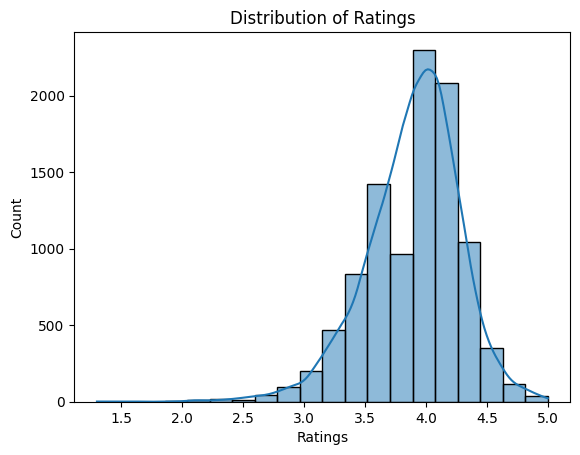

Epoch 0, Train Loss: 0.6830, Dev Loss: 0.6661
Epoch 100, Train Loss: 0.0624, Dev Loss: 0.0660
Epoch 200, Train Loss: 0.0135, Dev Loss: 0.0145
Epoch 300, Train Loss: 0.0054, Dev Loss: 0.0059
Epoch 400, Train Loss: 0.0029, Dev Loss: 0.0032
Epoch 500, Train Loss: 0.0018, Dev Loss: 0.0020
Epoch 600, Train Loss: 0.0012, Dev Loss: 0.0014
Epoch 700, Train Loss: 0.0009, Dev Loss: 0.0010
Epoch 800, Train Loss: 0.0007, Dev Loss: 0.0008
Epoch 900, Train Loss: 0.0005, Dev Loss: 0.0006


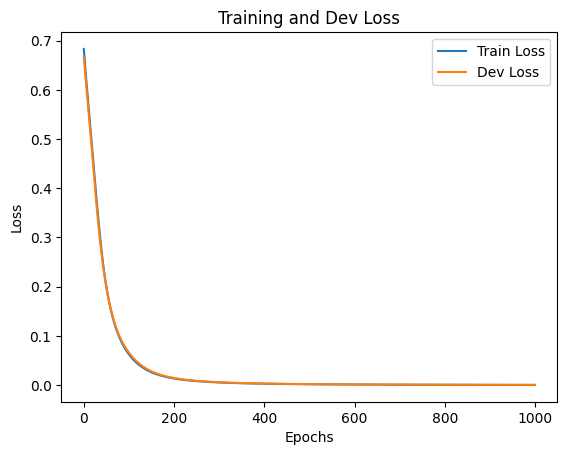

Test Accuracy: 100.00%


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("companies.csv")

# 1. Exploratory Data Analysis (EDA)
print(df.head())
print(df.info())
print(df.describe())

# Visualizing ratings distribution
sns.histplot(df['Ratings'], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.show()

# Missing code shown in Task Part 1

# 2. Perform train-dev-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Output activation for binary classification

    # 3. Implement forward propagation
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 10  # Number of neurons in the hidden layer
output_size = 1  # Binary classification
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork(input_size, hidden_size, output_size).to(device)
# Binary cross-entropy loss
# 4. Used to compute final cost function for binary classification
# by measuring the difference between predicted probabilities and actual labels.
# This cost function is used to optimize the neural network through backpropagation and weight updates
criterion = nn.BCELoss()
# 5. Adam optimizer is used here for gradient descent
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
epochs = 1000
train_losses = []
dev_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate on development set
    model.eval()
    with torch.no_grad():
        dev_outputs = model(X_dev_tensor.to(device))
        dev_loss = criterion(dev_outputs, y_dev_tensor.to(device))
        dev_losses.append(dev_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Dev Loss: {dev_loss.item():.4f}")

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(dev_losses, label='Dev Loss')

# Evaluate model on test set
model.eval()
with torch.no_grad():
    # 6. Present results using test set
    y_pred = model(X_test_tensor.to(device))
    y_pred_labels = (y_pred.cpu().numpy() > 0.5).astype(int)
    accuracy = np.mean(y_pred_labels.flatten() == y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


5. Experiment with normalized inputs i.e. comment on how your model performs when the inputs are normalized.

  Normalized inputs significantly imptove training efficiency and final performance. Without normalization the model would require more epochs to reach stable accuracy.

**Task 3**

Hyperparameter Selection:
- Hidden Layer Size: 10
  - This size was chosen to balance between model complexity and efficiency
  - Few neurons could lead to underfitting while too many can cause overfitting
  - 10 gives the most stable results

- Learning Rate: 0.01
  - This value was based on typical values for deep learning models
  - Lower learning rates resulted in slow convergence, while higher rates caused instability

- Epochs: 1000
  - Training 500 epochs showed improvement but never leveled out
  - Beyond 1000 epochs, overfitting signs appeared in the development set

  Regularization was not explicitly used, overfitting was monitored by the development loss. If overfitting was observed techniques like weight decay would have been introduced.

  The Adam Optimizer was used due to its efficiency in handling sparse gradients and adapting the learning rate dynamically. Adam provided faster conergence and stability compared to other optimizing techniques like SGD. It combines the benfits of Momentum and RMSprop.